In [1]:
# The aim of this notebook is to produce summary statistics for Hazards over a range of areas
# typical statistic include, median, min, max, 10th, 90th percentiles

In [2]:
# https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb

In [3]:
import calendar

import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np

In [4]:
from glob import glob 
import xarray as xr

In [5]:
crs = ccrs.LambertConformal(central_latitude = -24.75, central_longitude = 134.0,cutoff=30, standard_parallels=(-10,-40))


In [6]:
filelist = glob("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/CSIRO/ACCESS-CM2/ssp126/r4i1p1f1/CCAM-v2203-SN/v1-r1/day/tasmax/*")

# filelist = glob("/g/data/lp01/CORDEX-CMIP6/CMIP6/DD/gr1.5/CSIRO/ACCESS-CM2/ssp126/r4i1p1f1/CCAM-v2203-SN/v1-r1/mon/tas/v20231206/tas_gr1.5_ACCESS-CM2_ssp126_r4i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_mon_201501-209912.nc")

In [7]:
ds = xr.open_mfdataset(filelist,
                      preprocess= lambda ds: ds.resample(time = "1YE").mean(),
                      use_cftime = True)

In [8]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')
states_gp = states_gp[:-2] # exclude ACT and other territories 


In [9]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states"
)

In [10]:
states_regions

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory

[7 regions]

In [11]:
# for default mask if only concerned in centre is within mask
mask_centre = states_regions.mask_3D(ds)





In [12]:
# # fractional mask is more memory intensive and more relevant for coarse resolution data
# frac = states_regions.mask_3D_frac_approx(ds)

# fg = frac.plot(
#     subplot_kws=dict(projection=ccrs.PlateCarree()),
#     col="region",
#     col_wrap=4,
#     transform=ccrs.PlateCarree(),
#     cmap='Blues',
# )
# for ax in fg.axs.flatten():
#     ax.coastlines()
#     ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
#     ax.add_feature(cartopy.feature.STATES)
# plt.show()

In [ ]:
fg = mask_centre.plot(
    subplot_kws=dict(projection=crs),
    col="region",
    col_wrap=4,
    transform=crs,
    add_colorbar=False,
    cmap=mplc.ListedColormap(["none", "tab:orange"]),
)
for ax in fg.axs.flatten():
    ax.set_extent([110, 157, -8, -45], crs=crs)
    gdf_dict["aus_states_territories"].plot(ax=ax, facecolor="none", edgecolor="black",)
fg.fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

In [14]:
qld_mask = mask_centre.isel(region = (mask_centre.names == "Queensland"))


In [24]:
ds_qld = ds.where(qld_mask)#.mean(dim=["lon", "lat"])
ds_qld


<xarray.Dataset> Size: 2GB
Dimensions:   (time: 85, lat: 691, lon: 886, region: 1, bnds: 2)
Coordinates:
  * lat       (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * time      (time) object 680B 2015-12-31 00:00:00 ... 2099-12-31 00:00:00
  * region    (region) int64 8B 2
    abbrevs   (region) <U3 12B 'QLD'
    names     (region) <U18 72B 'Queensland'
Dimensions without coordinates: bnds
Data variables:
    tasmax    (time, lat, lon, region) float32 208MB dask.array<chunksize=(1, 691, 886, 1), meta=np.ndarray>
    lat_bnds  (time, lat, bnds, region, lon) float64 833MB dask.array<chunksize=(1, 691, 2, 1, 886), meta=np.ndarray>
    lon_bnds  (time, lon, bnds, region, lat) float64 833MB dask.array<chunksize=(1, 886, 2, 1, 691), meta=np.ndarray>
Attributes: (12/28)
    Conventions:             CF-1.10
    activity_id:             DD
    contact:                 ccam@csiro.au
    domain:                  Australia/AGCD
    domain_id:               AGCD-05i
    driving_experiment:      update of RCP2.6 based on SSP1
    ...                      ...
    variable_id:             tasmax
    input_tracking_id:       e85f5604-acda-4b0b-9155-912f71b77af2
    input_doi:               https://doi.org/10.25914/rd73-4m38
    title:                   Pre-processed model output in preparation for bi...
    history:                 Fri Apr 12 08:53:07 2024: ncatted -O -a least_si...
    NCO:                     netCDF Operators version 5.0.5 (Homepage = http:...

In [17]:
from datetime import datetime

In [18]:
ds_qld['tasmax'].isel(time=0)["time"].values

array(cftime.DatetimeProlepticGregorian(2015, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [19]:
import geopandas as gpd
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NRM, etc
gdf_dict = {}

shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]
for name in shape_files:
    gdf_dict.update({name: gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')})
gdf_dict.update({"broadacre_regions" : gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp')})

In [21]:
ds_qld

<xarray.Dataset> Size: 4kB
Dimensions:   (time: 85, region: 1, bnds: 2)
Coordinates:
  * time      (time) object 680B 2015-12-31 00:00:00 ... 2099-12-31 00:00:00
  * region    (region) int64 8B 2
    abbrevs   (region) <U3 12B 'QLD'
    names     (region) <U18 72B 'Queensland'
Dimensions without coordinates: bnds
Data variables:
    tasmax    (time, region) float32 340B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat_bnds  (time, bnds, region) float64 1kB dask.array<chunksize=(1, 2, 1), meta=np.ndarray>
    lon_bnds  (time, bnds, region) float64 1kB dask.array<chunksize=(1, 2, 1), meta=np.ndarray>

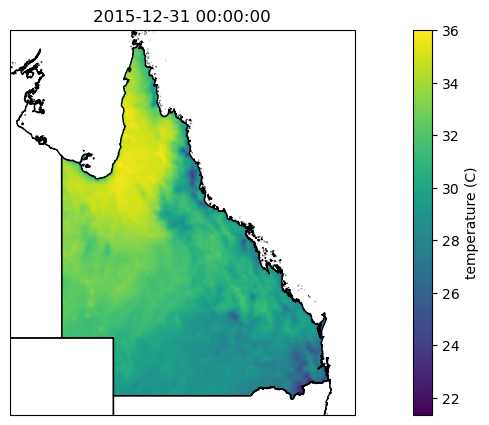

In [25]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=crs)
ds_qld['tasmax'].isel(time=0).plot(
    ax=ax,
    transform=crs,
    cbar_kwargs={'label': f'temperature (C)'},
)
ax.set_extent([135, 155, -10, -30], crs=crs )
ax.set_title(ds_qld['tasmax'].isel(time=0)["time"].values)
gdf_dict["aus_states_territories"].plot(ax=ax, facecolor="none", edgecolor="black",)

plt.show()